In [1]:
from glob import glob
import os
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import matplotlib.ticker as ticker
from matplotlib.collections import Collection, LineCollection
from matplotlib.artist import allow_rasterization
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as md
import matplotlib.ticker as ticker
from metpy.plots import ctables
#from pyPIPS import disdrometer_module as dis
from pyPIPS import pips_io as pipsio
from pyPIPS import timemodule as tm
from pyPIPS.utils import mtokm, getTimeWindow, interp_along_1D
from pyPIPS import plotmodule as pm
from pyPIPS import PIPS as pips
from pyPIPS import fmcw
from itertools import cycle
import netCDF4 as netcdf
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from skimage.restoration import unwrap_phase
import skimage.feature as SF
import numpy.ma as ma
from scipy import ndimage, interpolate
%load_ext autoreload
%autoreload 2
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Read in PIPS data
PIPS_data_dir = '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/full_PIPS_dataset/'
PIPS_filename = 'parsivel_combined_FMCW_2017_043017_PIPS2A_60s_new.nc'
PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
PIPS_ds = xr.open_dataset(PIPS_filepath)
print(PIPS_ds)

<xarray.Dataset>
Dimensions:                   (diameter_bin: 32, fallspeed_bin: 32, fields_KHTX: 49, parameter: 3, time: 1441)
Coordinates:
  * time                      (time) datetime64[ns] 2017-04-30T00:00:03 ... 2017-05-01T00:00:03
    fallspeed                 (fallspeed_bin) float64 ...
    diameter                  (diameter_bin) float64 ...
    min_diameter              (diameter_bin) float64 ...
    max_diameter              (diameter_bin) float64 ...
    min_fallspeeds            (fallspeed_bin) float64 ...
    max_fallspeeds            (fallspeed_bin) float64 ...
  * parameter                 (parameter) object 'N0' 'lamda' 'alpha'
  * fields_KHTX               (fields_KHTX) object 'N0_TMM_F' ... 'RR_TMM_F'
Dimensions without coordinates: diameter_bin, fallspeed_bin
Data variables:
    precipintensity           (time) float64 ...
    precipaccum               (time) float64 ...
    parsivel_dBZ              (time) float64 ...
    pcount                    (time) int64 ...
 

In [3]:
already_resampled = True
# fmcw_data_dir = '/Users/dawson29/sshfs_mounts/depot_robin/share/VORTEX-SE/2017/data/radar/umassfmcw/nc'
fmcw_data_dir = '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/FMCW/0430'
starttimestring = '201704302000'
endtimestring = '201704302359'
fmcw_output_dir = '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/FMCW/0430'
if not os.path.exists(fmcw_output_dir):
    os.makedirs(fmcw_output_dir)
        
if already_resampled:
    fmcw_filename = 'fmcw_merged_resampled_{}_{}.nc'.format(starttimestring, endtimestring)
    fmcw_filepath = os.path.join(fmcw_data_dir, fmcw_filename)
    fmcw_merged_dataset = xr.open_dataset(fmcw_filepath)

else:
    fmcw_filename = 'fmcw_merged_corrected_{}_{}.nc'.format(starttimestring, endtimestring)
    fmcw_filepath = os.path.join(fmcw_data_dir, fmcw_filename)
    fmcw_merged_dataset = xr.open_dataset(fmcw_filepath)
    fmcw_merged_resampled_ds = fmcw_merged_dataset.resample(time='10S').interpolate()
    fmcw_merged_ds_rolling = fmcw_merged_resampled_ds.rolling(time=6)
    fmcw_merged_resampled_ds = fmcw_merged_ds_rolling.mean()
    fmcw_merged_resampled_at_PIPS_ds = fmcw_merged_resampled_ds.interp_like(PIPS_ds)
    fmcw_merged_resampled_at_PIPS_ds.attrs = fmcw_merged_dataset.attrs
    fmcw_filename = 'fmcw_merged_resampled_{}_{}.nc'.format(starttimestring, endtimestring)
    fmcw_filepath = os.path.join(fmcw_output_dir, fmcw_filename)
    fmcw_merged_resampled_at_PIPS_ds.to_netcdf(fmcw_filepath)
    
print(fmcw_merged_dataset)

<xarray.Dataset>
Dimensions:   (height: 1024, time: 301, vels: 256)
Coordinates:
  * height    (height) float64 1.0 5.0 10.0 ... 5.105e+03 5.11e+03 5.115e+03
  * vels      (vels) float32 -7.314703 -7.257557 ... 7.2004104 7.257557
  * time      (time) datetime64[ns] 2017-04-30T19:00:03 ... 2017-05-01T00:00:03
Data variables:
    Zef       (time, height, vels) float64 ...
    sf        (time, height, vels) float64 ...
    sn        (time, height) float64 ...
    sff       (time, height, vels) float64 ...
    snr       (time, height) float64 ...
    Ze        (time, height) float64 ...
    vel       (time, height) float64 ...
    wid       (time, height) float64 ...
    vel_da    (time, height) float64 ...
    Ze_corr   (time, height) float64 ...
    Zef_corr  (time, height, vels) float64 ...
Attributes:
    NetCDFRevision:  UMass MIRSL FMCW V1.0
    RadarName:       UMa-FMCW
    PRF:             287.224
    Frequency:       2945000000.0
    Latitude:        34.6872
    Longitude:       -

In [ ]:
#PIPS_ds.load()
#PIPS_new_file = 'parsivel_combined_FMCW_2017_043017_PIPS2A_60s_new.nc'
#PIPS_new_filepath = os.path.join(PIPS_data_dir, PIPS_new_file)
#PIPS_ds.to_netcdf(PIPS_new_filepath)

In [ ]:
print(PIPS_ds['KHTX_beam_height_at_PIPS'])

In [4]:
%matplotlib inline
# plt.rcParams["figure.figsize"] = (20,10)
# fmcw.plot_fmcw_4panel_xarray(fmcw_merged_dataset)

<xarray.Dataset>
Dimensions:   (height: 1024, time: 301, vels: 256)
Coordinates:
  * height    (height) float64 1.0 5.0 10.0 ... 5.105e+03 5.11e+03 5.115e+03
  * vels      (vels) float32 -7.314703 -7.257557 ... 7.2004104 7.257557
  * time      (time) datetime64[ns] 2017-04-30T19:00:03 ... 2017-05-01T00:00:03
Data variables:
    Zef       (time, height, vels) float64 ...
    sf        (time, height, vels) float64 ...
    sn        (time, height) float64 ...
    sff       (time, height, vels) float64 ...
    snr       (time, height) float64 ...
    Ze        (time, height) float64 ...
    vel       (time, height) float64 ...
    wid       (time, height) float64 ...
    vel_da    (time, height) float64 ...
    Ze_corr   (time, height) float64 ...
    Zef_corr  (time, height, vels) float64 ...
Attributes:
    NetCDFRevision:  UMass MIRSL FMCW V1.0
    RadarName:       UMa-FMCW
    PRF:             287.224
    Frequency:       2945000000.0
    Latitude:        34.6872
    Longitude:       -

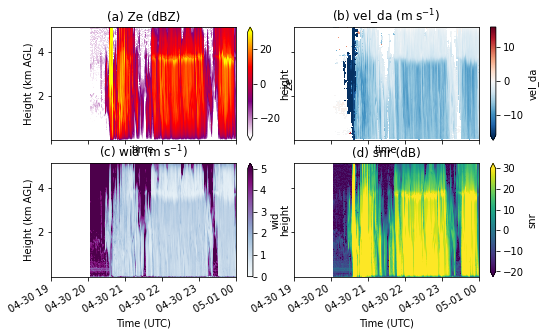

In [5]:
fmcw_merged_resampled_at_PIPS_ds = fmcw_merged_dataset
print(fmcw_merged_resampled_at_PIPS_ds)
fmcw.plot_fmcw_4panel_xarray(fmcw_merged_resampled_at_PIPS_ds)

In [ ]:
if not already_merged:
    fmcw_merged_dataset = fmcw.correct_fmcw_with_nexrad(fmcw_merged_dataset, PIPS_ds, radar_name='KHTX', 
                                                        dBZ_field='REF', plot=True)
    print(fmcw_merged_dataset['Ze'])
    print(fmcw_merged_dataset['Ze_corr'])
    fmcw.plot_fmcw_4panel_xarray(fmcw_merged_dataset, dBZ_var='Ze_corr')
    print(fmcw_merged_dataset)
    fmcw_output_dir = '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/FMCW/0430'
    if not os.path.exists(fmcw_output_dir):
        os.makedirs(fmcw_output_dir)
    fmcw_filename = 'fmcw_merged_corrected_{}_{}.nc'.format(starttimestring, endtimestring)
    fmcw_filepath = os.path.join(fmcw_output_dir, fmcw_filename)
    fmcw_merged_dataset.to_netcdf(fmcw_filepath)

/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


(1441, 32)


/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log10
No handles with labels found to put in legend.


<xarray.DataArray 'height' ()>
array(500.)
Coordinates:
    height   float64 500.0
<xarray.DataArray 'Ze_corr' (time: 301)>
array([      nan,       nan,       nan, ..., 23.70033 , 22.834305, 14.962478])
Coordinates:
    height   float64 500.0
  * time     (time) datetime64[ns] 2017-04-30T19:00:03 ... 2017-05-01T00:00:03
start_datetime 2017-04-30 20:00:00
end_datetime 2017-04-30 23:59:00


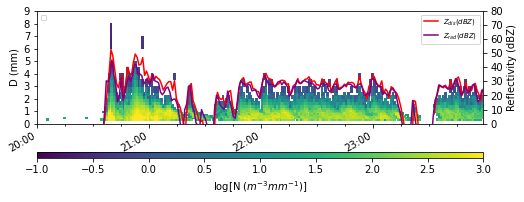

In [6]:
import pyPIPS.parsivel_params as pp
import pyPIPS.polarimetric as dp
min_diameter = pp.parsivel_parameters['min_diameter_bins_mm']
max_diameter = pp.parsivel_parameters['max_diameter_bins_mm']
bin_width = max_diameter - min_diameter
avg_diameter = pp.parsivel_parameters['avg_diameter_bins_mm']
min_fall_bins = pp.parsivel_parameters['min_fallspeed_bins_mps']
max_fall_bins = pp.parsivel_parameters['max_fallspeed_bins_mps']
avg_fall_bins = pp.parsivel_parameters['avg_fallspeed_bins_mps']

vd_matrix_da = PIPS_ds['VD_matrix_qc']
ND = PIPS_ds['ND_qc']
logND = np.log10(ND)

# conv_df = pips.calc_thermo(conv_df)
# # empirical_fallspeed = pips.calc_empirical_fallspeed(avg_diameter)
# fallspeed_spectrum = pips.calc_fallspeed_spectrum(avg_diameter, avg_fall_bins, correct_rho=True,
#                                                   rho=conv_df['rho'])
# vd_matrix_da = vd_matrix_da.where(vd_matrix_da > 0.0)
# ND = pips.calc_ND(vd_matrix_da, fallspeed_spectrum, 10.)
# ND = ND.T
# logND = np.log10(ND)
# logND = 

PSD_datetimes = pips.get_PSD_datetimes(vd_matrix_da)
PSD_datetimes_dict = pips.get_PSD_time_bins(PSD_datetimes)

PSD_edgetimes = md.date2num(PSD_datetimes_dict['PSD_datetimes_edges'])
PSD_centertimes = md.date2num(PSD_datetimes_dict['PSD_datetimes_centers'])

# ND = PIPS_dict['ND'].T
# logND = ma.log10(ND)
# DSD_index = PIPS_dict['DSD_index']
# DSD_interval = PIPS_dict['DSD_interval']
# DSD_interval_td = timedelta(seconds=DSD_interval)
# DSD_halfinterval_td = timedelta(seconds=DSD_interval / 2.)

# Determine start and end times/indices for analysis
# PSDtimestamps = PIPS_dict['PSDtimestamps']
# PSDtimestampsnums = md.date2num(PSDtimestamps)

#     plotstarttime = starttime
#     plotstoptime = stoptime

# pstartindex, pstopindex = getTimeWindow(starttimestring, endtimestring, PSDtimestampsnums)

# pstarttime = PSDtimestampsnums[pstartindex]
# pstoptime = PSDtimestampsnums[pstopindex]

# plotstarttime = pstarttime
# plotstoptime = pstoptime

# PSDtimestamps_edge = [x - DSD_interval_td for x in PSDtimestamps]
# # Add an extra 10 sec for the last time bin boundary
# PSDtimestamps_edge.append(PSDtimestamps_edge[-1] + DSD_interval_td)
# PSDtimestamps_avg = [x - DSD_halfinterval_td for x in PSDtimestamps]
# PSDstarttimes = md.date2num(PSDtimestamps_edge[pstartindex:pstopindex + 1])
# PSDmidtimes = md.date2num(PSDtimestamps_avg[pstartindex:pstopindex + 1])

scattfile = '/Users/terrell8/Projects/pyPIPS/tmatrix/FMCW/SCTT_RAIN_fw100.dat'
# Observed DSD: TODO, need to make ND, ND_expDSD, and ND_gamDSD have consistent units!
dualpol_dis = dp.calpolrain(15.0, scattfile, ND, bin_width)
#print(dualpol_dis)
dis_ref = dualpol_dis.get('REF', np.empty((0)))
logND_plot = logND.T
disvars = {'min_diameter': min_diameter, 'PSDstarttimes': PSD_edgetimes,
           'PSDmidtimes': PSD_centertimes, 'logND': logND_plot}
disvars['REF'] = dis_ref

# Quick and dirty rayleigh scattering approximation

M6 = []
print(ND.shape)
for t in range(ND.shape[0]):
    temp_M6 = ((avg_diameter[:] / 1000.)**6.) * (1000. * ND[t, :]) * bin_width[:] / 1000.
    temp_M6 = np.nansum(temp_M6)
    M6.append(temp_M6)

M6 = np.array(M6, dtype=np.float64)
refl_disd = 10.0 * np.log10(1e18 * M6)
#disvars['dBZ'] = refl_disd

# fig, ax = plt.subplots(figsize=(8, 3))

# ax.plot(PSD_centertimes, disvars['dBZ'])

radz = 500. # (m) Height of FMCW gate to plot
radzindex = int(radz/5.)

plotx_rad = fmcw_merged_dataset['time'].values
#dBZ_D_plt = fmcw_merged_dataset['Ze'].values[:, radzindex] + 10.**(2.*7.3/10.)
dBZ_D_plt = fmcw_merged_dataset['Ze_corr'].values[:, radzindex]


print(fmcw_merged_dataset['height'][radzindex])
print(fmcw_merged_dataset['Ze_corr'][:, radzindex])

# fmcw_merged_dataset['Ze'][:, radzindex].plot()

# print(dBZ_D_plt)

radvars = {'radmidtimes': plotx_rad, 'REF': dBZ_D_plt}

# Prepare axis parameters
# timelimits = [md.date2num(datetime.strptime(starttimestring, tm.timefmt3)),
#               md.date2num(datetime.strptime(endtimestring, tm.timefmt3))]
# timelimits = [md.date2num(datetime.strptime('20170430203000', tm.timefmt3)),
#               md.date2num(datetime.strptime('20170430210000', tm.timefmt3))]
# Set up axis parameters
start_time = '20170430200000'
end_time = '20170430235900'
try:
    start_datetime = datetime.strptime(start_time, tm.timefmt3)
    print('start_datetime', start_datetime)
except (ValueError, TypeError):
    start_datetime = PSD_edgetimes[0]
try:
    end_datetime = datetime.strptime(end_time, tm.timefmt3)
    print('end_datetime', end_datetime)
except (ValueError, TypeError):
    end_datetime = PSD_edgetimes[-1]
timelimits = [start_datetime, end_datetime]
diamlimits = [0.0, 9.0]
diamytick = 1.0

locator = md.HourLocator(interval=1)
minorlocator = md.MinuteLocator(byminute=[0,15,30,45])
# minorlocator = md.HourLocator(interval=1)
#dateformat = '%d/%H'
dateformat = '%H:%M'
formatter = md.DateFormatter(dateformat)
axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

            # Ok, now we should have everything ready to go to plot the meteograms.
            # Let'er rip!
meteogram_image_dir = './'
dis_plot_name = 'PIPS1A_observed'
pm.plotDSDmeteograms(dis_plot_name, meteogram_image_dir,
                     axparams, disvars, radvars.copy(), close_fig=False)

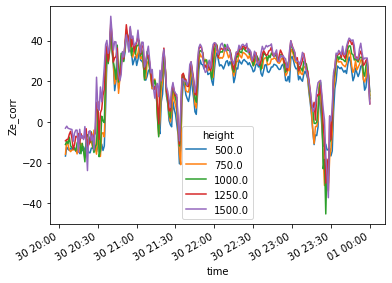

In [7]:
dBZ_D_plt = fmcw_merged_resampled_at_PIPS_ds['Ze_corr']
dBZ_D_plt.sel(height=[500., 750., 1000., 1250., 1500.]).plot.line(x='time')

/Users/terrell8/miniconda2/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


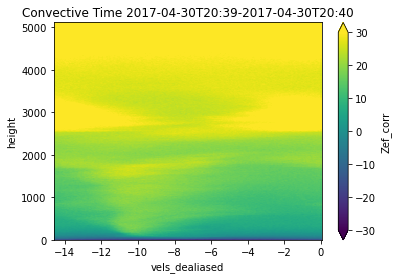

In [13]:
start_time = '2017-04-30T20:39'
end_time = '2017-04-30T20:40'
vbins = fmcw_merged_resampled_at_PIPS_ds['vels']
vbins_dealias = vbins - vbins[-1]
fmcw_merged_resampled_at_PIPS_ds.coords['vels_dealiased'] = ('vels', vbins_dealias)
#print(fmcw_merged_resampled_at_PIPS_ds)
Zef_corr = fmcw_merged_resampled_at_PIPS_ds['Zef_corr']
#print(Zef_corr)
#print(Zef_corr.loc['2017-04-30T22:40':'2017-04-30T22:41'])
zef_corr_convective = Zef_corr.loc[start_time:end_time].mean(dim="time")
#Zef_corr_2240 = Zef_corr.sel(time='2017-04-30T22:40:03')
# print(Zef_corr_2240)
#Zef_corr_2240 = Zef_corr_2240.roll(vels=128, roll_coords=False)
zef_corr_convective = zef_corr_convective.roll(vels=128, roll_coords=False)
#delta_v = Zef_corr_2240.vels[1] - Zef_corr_2240.vels[0]
#print(2. / delta_v)
#shift = int(2. / delta_v)
#Zef_corr_2240_shifted = Zef_corr_2240.roll(vels=shift, roll_coords=False)
#Zef_corr_2240_z2000 = Zef_corr_2240.sel(height=2000.)
zef_corr_convective.plot(x='vels_dealiased', y='height', vmin=-30, vmax=30)
plt.title('Convective Time {}-{}'.format(start_time, end_time))
#fig2, ax2 = plt.subplots()
#Zef_corr_2240_shifted.plot(ax=ax2, vmin=-30, vmax=30)
#fig, ax = plt.subplots()
#Zef_corr_2240_z2000.plot(ax=ax, x='vels_dealiased')
#Zef_corr_2240.plot(vmin=0., vmax=40.)

plot_dir = '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/FMCW/0430'
plot_filename = 'velocity_spectrum_vs_height_{}_{}.png'.format(start_time, end_time)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_path = os.path.join(plot_dir, plot_filename)
plt.savefig(plot_path, bbox_inches='tight')

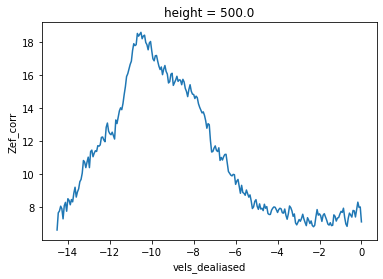

In [15]:
zef_corr_convective_500 = zef_corr_convective.sel(height=500.)
zef_corr_convective_500.plot(x='vels_dealiased')

In [ ]:
# Let's make a ridge plot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

print(df)


Zef_corr_2230_thinned = Zef_corr_2230.thin({'height': 100})

Zef_corr_2230_df = Zef_corr_2230_thinned.to_dataframe().reset_index()
print(Zef_corr_2230_df)
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(Zef_corr_2230_df, row="height", hue='height', aspect=2, height=1., palette=pal)

# Draw the densities in a few steps
#g.map(sns.kdeplot, "vels_dealiased", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
#g.map(sns.kdeplot, "vels_dealiased", clip_on=False, color="w", lw=2, bw=.2)
g.map(sns.lineplot, "vels_dealiased", "Zef_corr", clip_on=False, alpha=1, lw=1.5)
#g.map(sns.lineplot, "vels_dealiased", "Zef_corr", clip_on=False, color="w", lw=2, bw=.2)
#g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "vels_dealiased")

# Set the subplots to overlap
# g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
#g.set(yticks=[])
#g.despine(bottom=True, left=True)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m
print(df)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)